In [3]:
!pip install statsmodels
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

Cloning into '21-Days-21-Projects-Dataset'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 1.40 MiB | 5.40 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


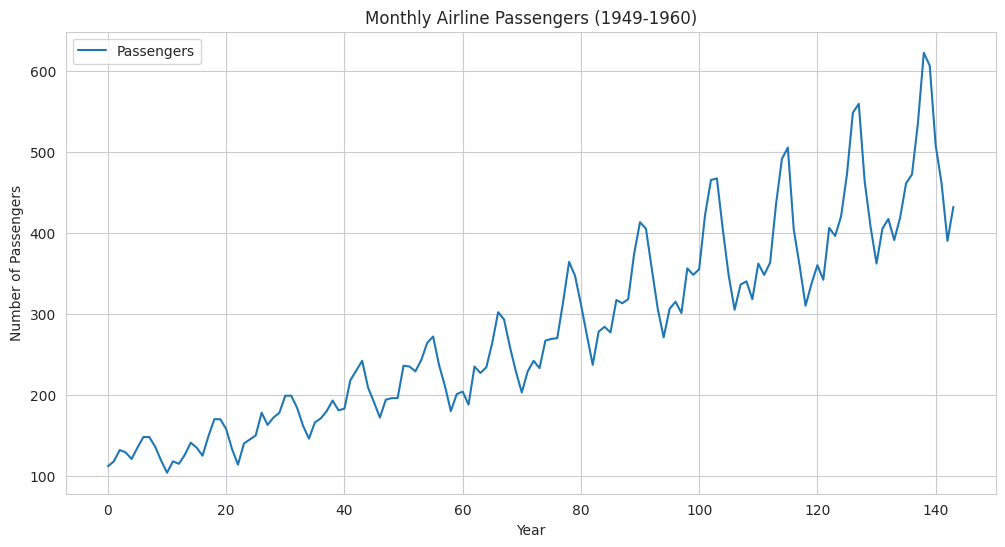

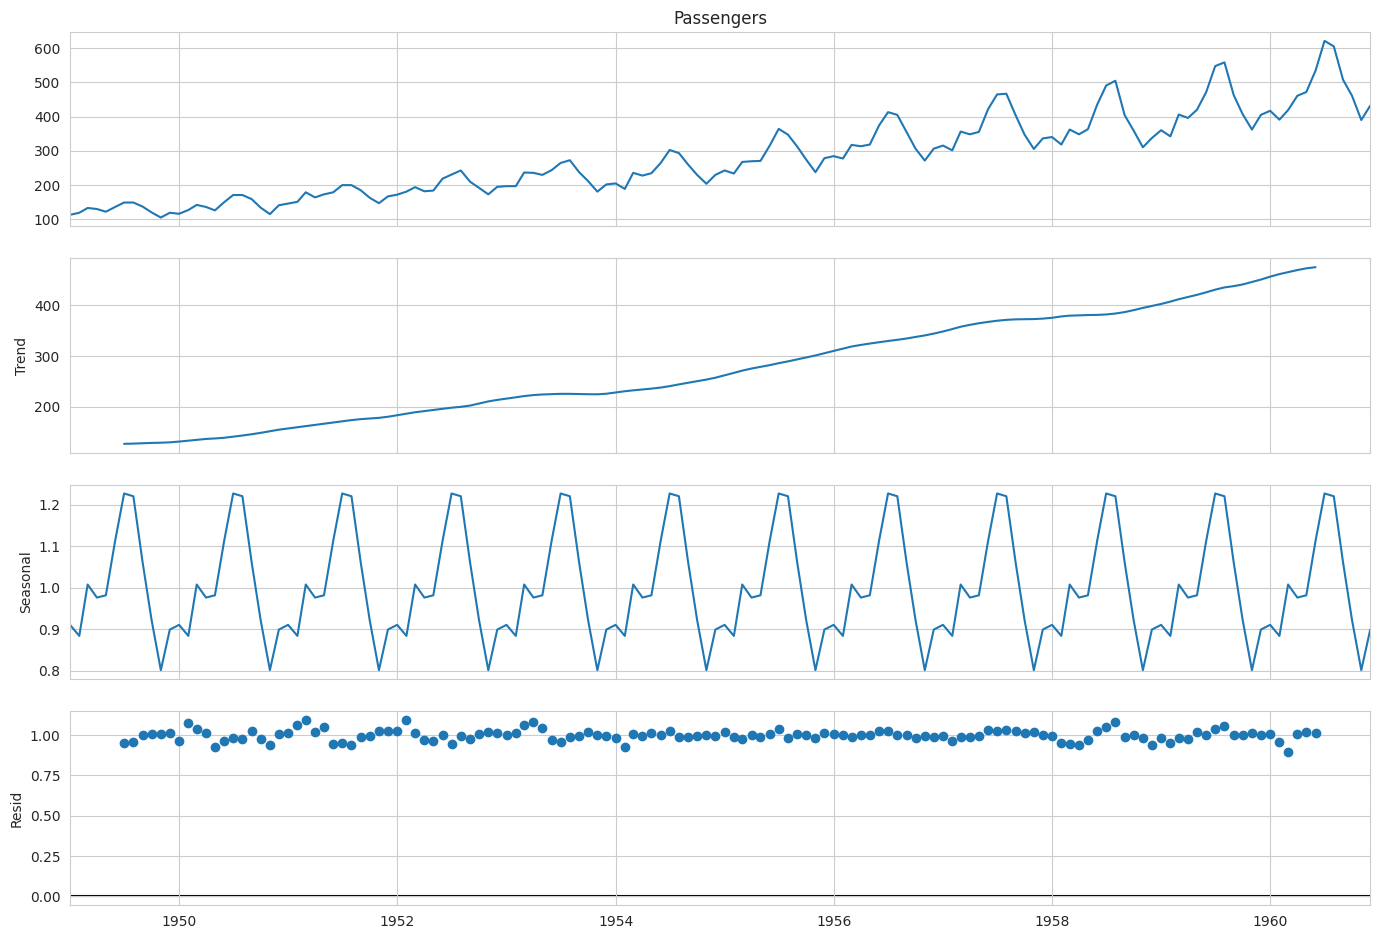

In [6]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

In [7]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


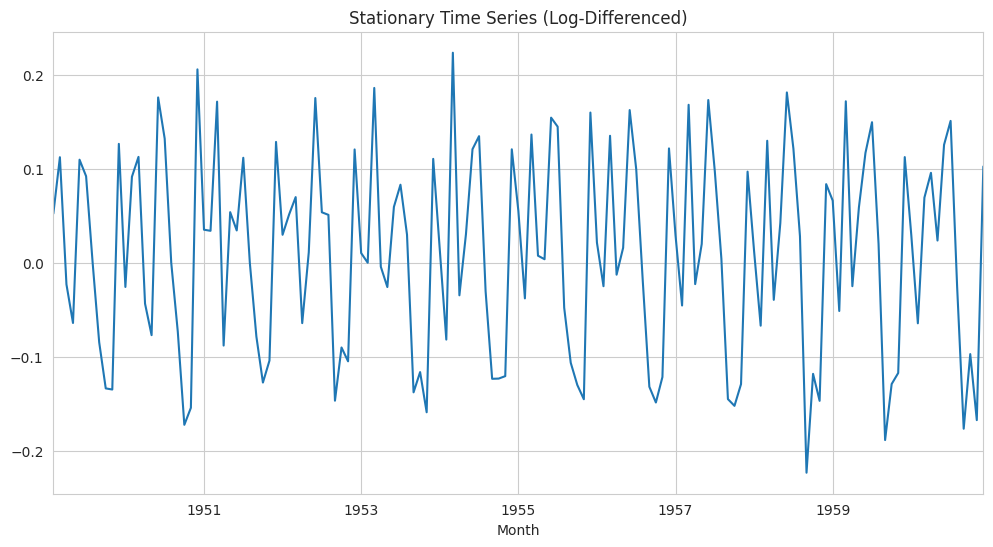

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [8]:
# 1. Apply log transformation to stabilize the variance
df_log = np.log(df['Passengers'])

# 2. Apply differencing to remove the trend
df_diff = df_log.diff().dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

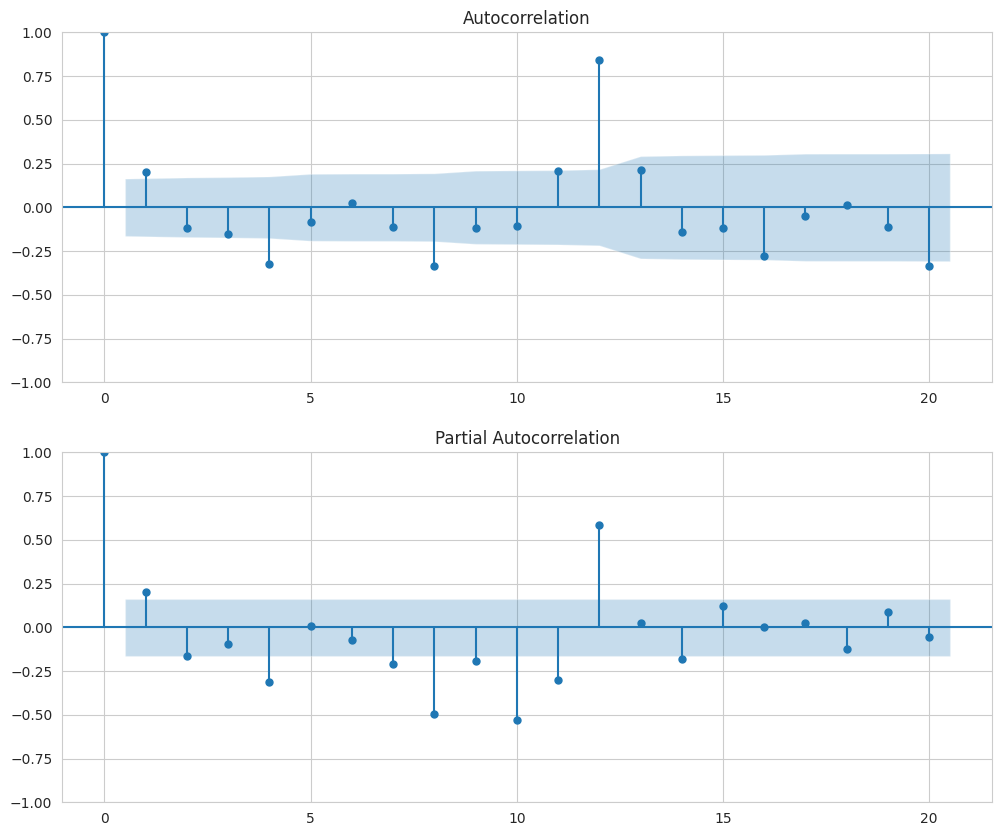

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

ARIMA MODEL


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


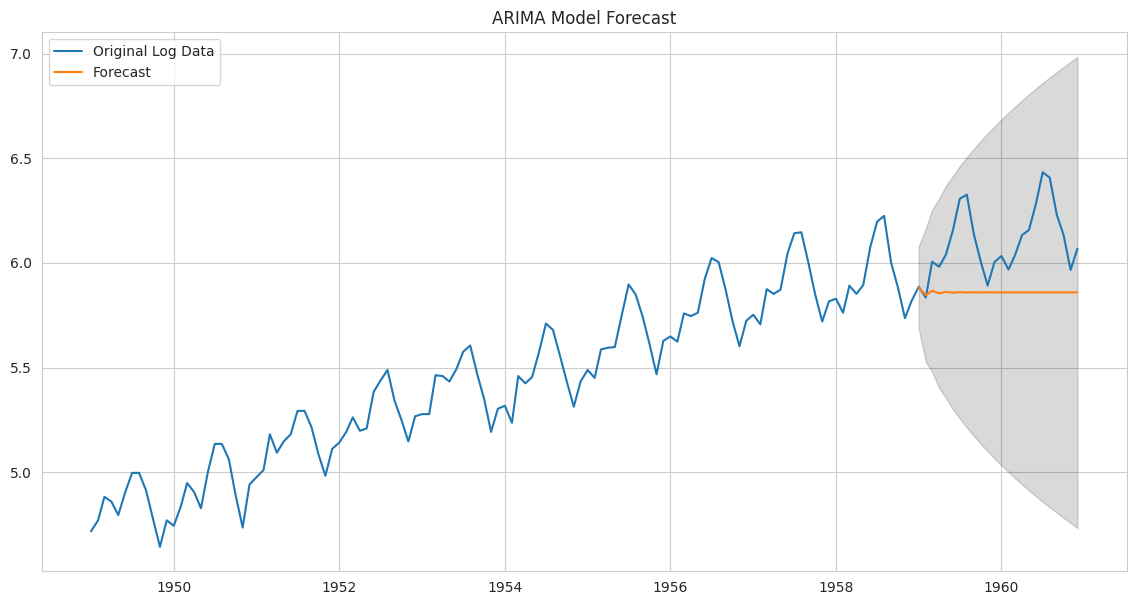

In [10]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

SARIMA MODEL


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


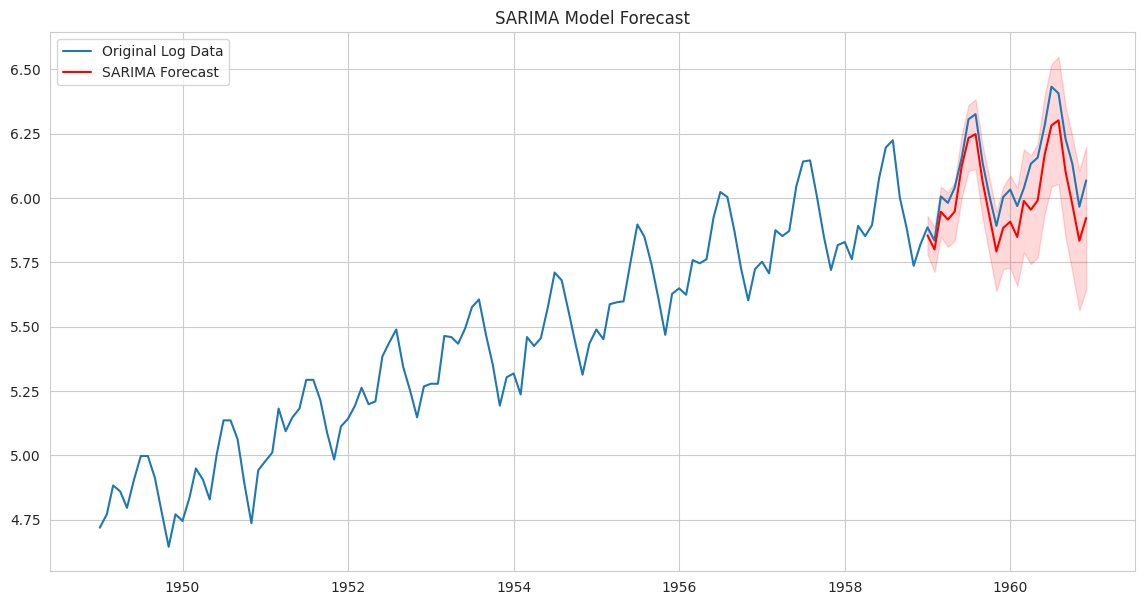

In [11]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

APPPLYING AND CHECKING WITH LOG TRANSFORMATIONS

In [12]:
df_log = np.log(df['Passengers'])

In [13]:
train_data = df_log[:'1958']
test_data = df_log['1959':]

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


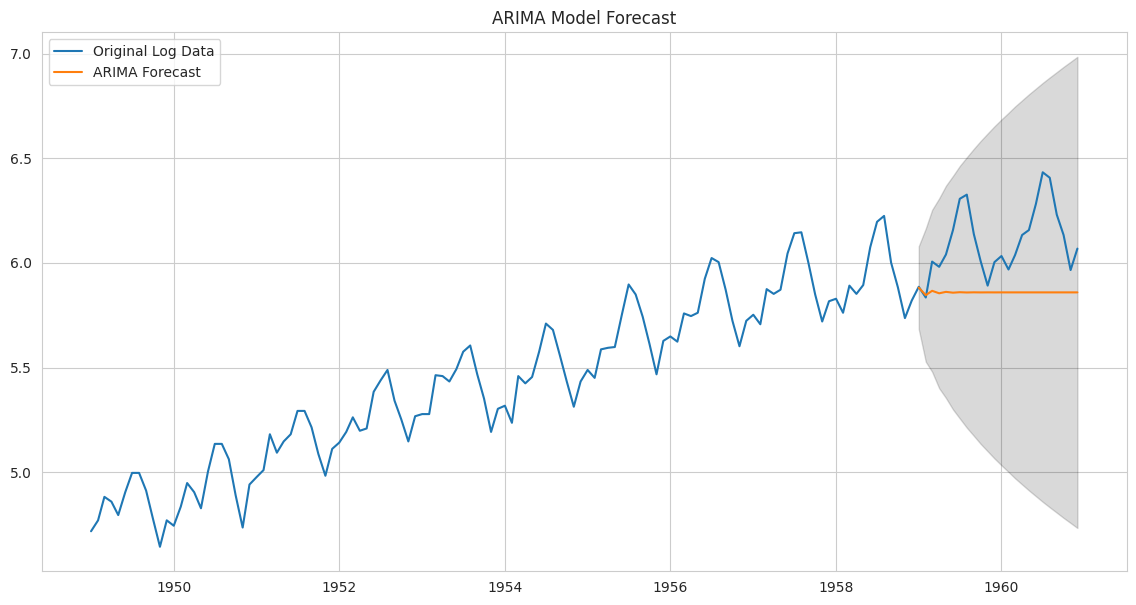

In [14]:
# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='ARIMA Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


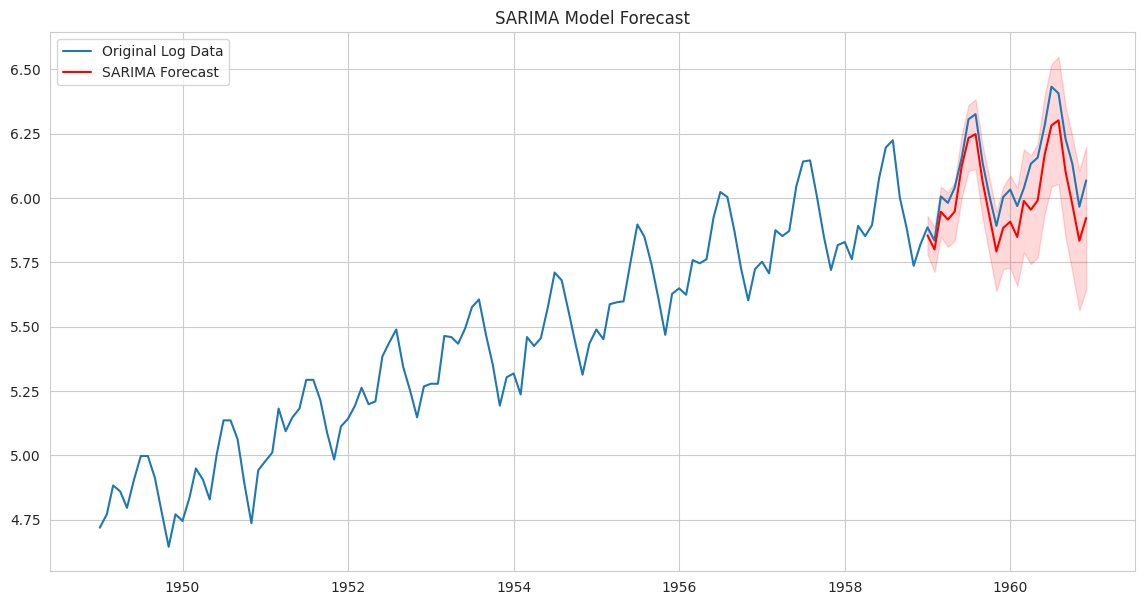

In [15]:
# Build SARIMA model
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

ARIMA Model RMSE: 0.2893
SARIMA Model RMSE: 0.1092


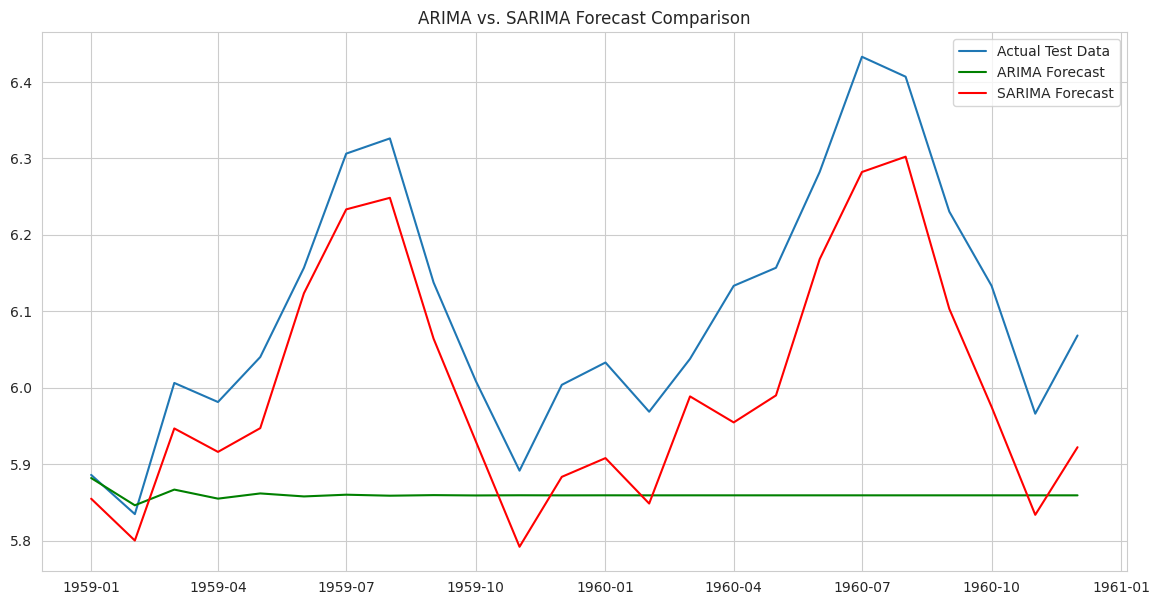

In [17]:
# Calculate RMSE for ARIMA model manually
arima_mse = mean_squared_error(test_data, forecast.predicted_mean)
arima_rmse = np.sqrt(arima_mse)
print(f'ARIMA Model RMSE: {arima_rmse:.4f}')

# Calculate RMSE for SARIMA model manually
sarima_mse = mean_squared_error(test_data, sarima_forecast.predicted_mean)
sarima_rmse = np.sqrt(sarima_mse)
print(f'SARIMA Model RMSE: {sarima_rmse:.4f}')

# Plot actual vs. forecast for comparison
plt.figure(figsize=(14, 7))
plt.plot(test_data, label='Actual Test Data')
plt.plot(forecast.predicted_mean, label='ARIMA Forecast', color='green')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.title('ARIMA vs. SARIMA Forecast Comparison')
plt.legend()
plt.show()

## Summary:

### Data Analysis Key Findings

*   Log transformation was successfully applied to the 'Passengers' column of the DataFrame.
*   The log-transformed data was split into training and testing sets, with the training data including observations up to the end of 1958 and the testing data from the beginning of 1959 onwards.
*   A non-seasonal ARIMA model with order (1, 1, 1) was built and fitted to the log-transformed training data.
*   A SARIMA model with order (1, 1, 1) and seasonal order (1, 1, 1, 12) was built and fitted to the log-transformed training data.
*   The Root Mean Squared Error (RMSE) for the ARIMA model on the test data was 0.2893.
*   The Root Mean Squared Error (RMSE) for the SARIMA model on the test data was 0.1092.

### Insights or Next Steps

*   The SARIMA model significantly outperformed the non-seasonal ARIMA model in forecasting the log-transformed airline passenger data, as indicated by its substantially lower RMSE. This highlights the importance of explicitly modeling seasonality in this dataset.
*   Further analysis could involve exploring different orders for the SARIMA model, evaluating performance with other metrics, and potentially back-transforming the forecasts to the original scale for easier interpretation and comparison with the original data.


QUESTIONS AND DISCUSSIONS


EDA :

there is upward trend in no of passengers over years
the pattern is seasonal and there are peaks and drops in each year almost at same time interval

STATIONARITY TESTING

A stationary time series is one whose statistical properties (mean, variance, autocorrelation) do not change over time.

IT IS IMPORTANT FOR TIME SERIS MODELS BECAUSE THE MODELS ASSUME DATA IS STATIONARY
NON STATIONARY DATA CAN GIVE MISLEADING RESULTS ANS POOR MODEL PERFORANCE


ADF TEST
The Augmented Dickey-Fuller (ADF) test on the original 'Passengers' data resulted in a p-value of 0.991880. Since this p-value is much greater than 0.05, we fail to reject the null hypothesis. This indicates that the original time series is non-stationary

EFFECT OF LOG TRANSFORMATION ⁉

applying log transformations stabalised variance of time seris data
the p value is decreased to be optimum i.e <0.05
while log transformation is a crucial step for this dataset to stabilize variance, it's the combination with differencing that effectively reduced the p-value towards stationarity.

ARIMA MODEL PERFORMANCE



Based on the high p-value of the ADF test on the original data (which would likely still be high after just a log transformation), a non-seasonal ARIMA model without differencing would not be expected to perform well on the log-transformed data. ARIMA models rely on the data being stationary after the specified differencing, and if it's not, the model's assumptions are violated, leading to poor forecasts. The SARIMA model is expected to perform better because it explicitly accounts for seasonality.

